In [1]:
import numpy as np
import os
import random
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
image_path = '/kaggle/input/heart-segmentation-images/img'
mask_path= '/kaggle/input/heart-segmentation-mask-images/masks_heart'

In [3]:
image_list = os.listdir(image_path)

mask_list = [filename for filename in image_list]
print(len(image_list))
print(len(mask_list))

238
238


In [4]:
for i in range(len(image_list)):
  print(image_list[i],"----",mask_list[i])

CHNCXR_0092_0.png ---- CHNCXR_0092_0.png
MCUCXR_0017_0.png ---- MCUCXR_0017_0.png
CHNCXR_0041_0.png ---- CHNCXR_0041_0.png
CHNCXR_0036_0.png ---- CHNCXR_0036_0.png
MCUCXR_0020_0.png ---- MCUCXR_0020_0.png
MCUCXR_0030_0.png ---- MCUCXR_0030_0.png
MCUCXR_0013_0.png ---- MCUCXR_0013_0.png
MCUCXR_0354_1.png ---- MCUCXR_0354_1.png
MCUCXR_0044_0.png ---- MCUCXR_0044_0.png
CHNCXR_0074_0.png ---- CHNCXR_0074_0.png
CHNCXR_0013_0.png ---- CHNCXR_0013_0.png
MCUCXR_0255_1.png ---- MCUCXR_0255_1.png
MCUCXR_0399_1.png ---- MCUCXR_0399_1.png
MCUCXR_0027_0.png ---- MCUCXR_0027_0.png
MCUCXR_0043_0.png ---- MCUCXR_0043_0.png
MCUCXR_0063_0.png ---- MCUCXR_0063_0.png
MCUCXR_0048_0.png ---- MCUCXR_0048_0.png
CHNCXR_0032_0.png ---- CHNCXR_0032_0.png
CHNCXR_0049_0.png ---- CHNCXR_0049_0.png
CHNCXR_0068_0.png ---- CHNCXR_0068_0.png
MCUCXR_0294_1.png ---- MCUCXR_0294_1.png
CHNCXR_0095_0.png ---- CHNCXR_0095_0.png
MCUCXR_0266_1.png ---- MCUCXR_0266_1.png
MCUCXR_0173_1.png ---- MCUCXR_0173_1.png
CHNCXR_0098_0.pn

In [5]:
def getData(shape):
    im_array = []
    mask_array = []
    shape = (shape, shape)
    # shape = image_size
    for i in tqdm(image_list): 
      # im.shape = (shape, shape, 1)
      im = cv2.imread(os.path.join(image_path,i))
      im= cv2.bitwise_not(im)
      im = cv2.resize(im, shape)[:, :, 0]
      im = cv2.equalizeHist(im)
      # mask.shape = (shape, shape, 1)
      mask = cv2.imread(os.path.join(mask_path, i))
      mask = cv2.resize(mask, shape)[:, :, 0]

   
      
      im_array.append(im)
      mask_array.append(mask)

      

    return im_array, mask_array

In [6]:
dim = 512
image_arr, mask_arr = getData(dim)

100%|██████████| 238/238 [00:35<00:00,  6.65it/s]


In [7]:
image_arr = np.array(image_arr).reshape(len(image_arr), dim, dim, 1)
mask_arr = np.array(mask_arr).reshape(len(mask_arr), dim, dim, 1)

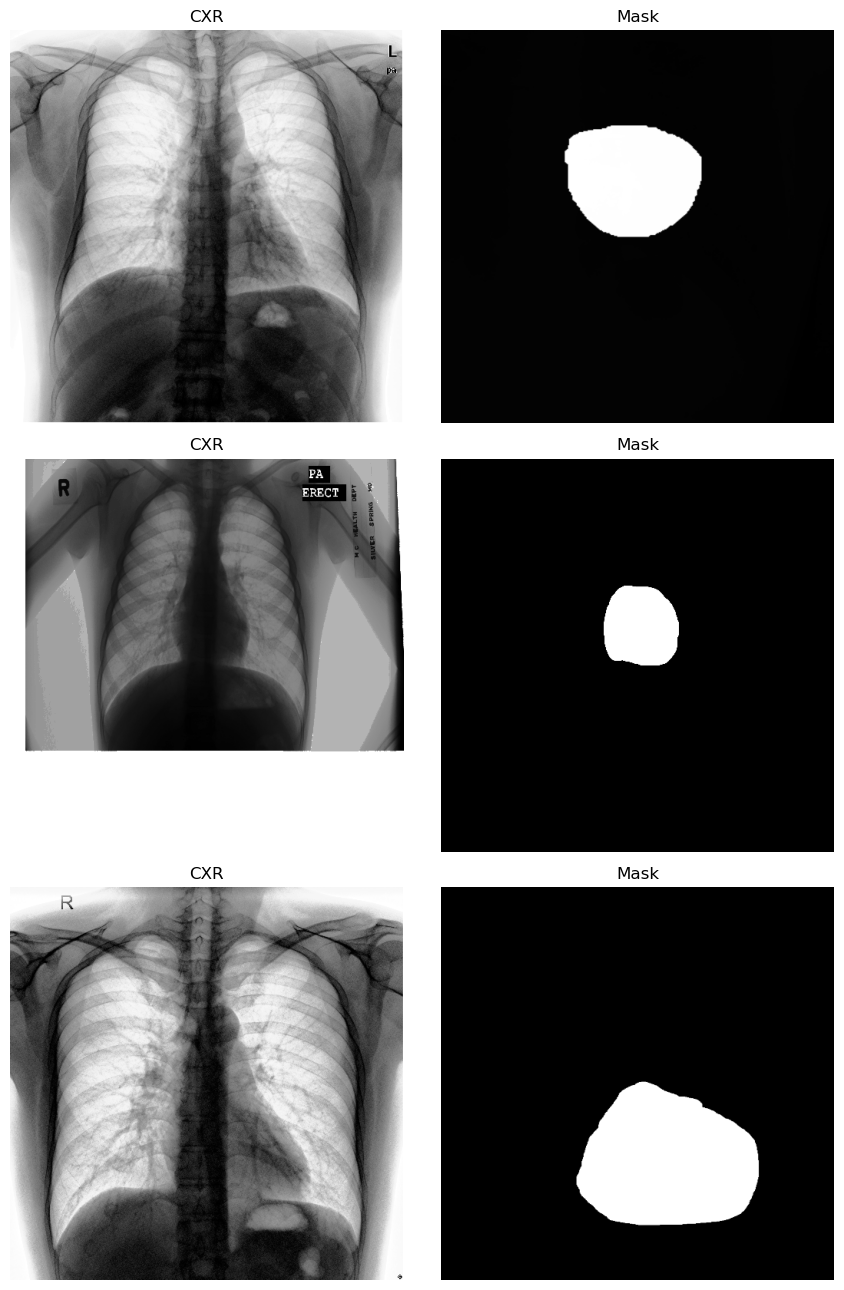

In [8]:
def scale_image(image):
    image_min = np.min(image)
    image_max = np.max(image)
    scaled_image = (image - image_min) / (image_max - image_min)
    contrast_adjusted_image = (scaled_image - 0.5) * 1.2 + 0.5  
    return np.clip(contrast_adjusted_image, 0.0, 1.0)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))

for i in range(3):
    axs[i, 0].imshow(np.squeeze(image_arr[i]), vmin=0, vmax=255, cmap='gray')
    axs[i, 0].set_ylabel('Image')
    axs[i, 0].set_title('CXR')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(np.squeeze(mask_arr[i]), vmin=0, vmax=255, cmap='gray')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split((image_arr - 127.0) / 127.0, 
                                                  (mask_arr > 127).astype(np.float32), 
                                                  test_size = 0.1, 
                                                  random_state = 42 )
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(214, 512, 512, 1) (24, 512, 512, 1) (214, 512, 512, 1) (24, 512, 512, 1)


**Implementation 1**

In [15]:
print(h.history.keys())

dict_keys(['loss', 'dice_coef', 'iou', 'val_loss', 'val_dice_coef', 'val_iou', 'lr'])


In [17]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [18]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [19]:
model = build_unet(input_shape=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), loss=dice_loss,
                  metrics=[dice_coef, iou, Recall(), Precision()])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 alization)                     )                                                             

In [20]:
weight_path="{}_weights.best.hdf5".format('cxr_heart')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [21]:
h = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=4, epochs=50,
                callbacks= callbacks_list)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.6021 - dice_coef: 0.3991 - iou: 0.2561 - recall: 0.7430 - precision: 0.2950
Epoch 1: val_loss improved from inf to 0.71133, saving model to cxr_heart_weights.best.hdf5
54/54 [==============================] - 58s 603ms/step - loss: 0.6021 - dice_coef: 0.3991 - iou: 0.2561 - recall: 0.7430 - precision: 0.2950 - val_loss: 0.7113 - val_dice_coef: 0.2887 - val_iou: 0.1701 - val_recall: 0.9568 - val_precision: 0.1881 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.4318 - dice_coef: 0.5677 - iou: 0.4009 - recall: 0.7172 - precision: 0.5266
Epoch 2: val_loss improved from 0.71133 to 0.56200, saving model to cxr_heart_weights.best.hdf5
54/54 [==============================] - 26s 487ms/step - loss: 0.4318 - dice_coef: 0.5677 - iou: 0.4009 - recall: 0.7172 - precision: 0.5266 - val_loss: 0.5620 - val_dice_coef: 0.4380 - val_iou: 0.2829 - val_recall: 0.9047 - val_precision: 0.3158 - lr: 0.001

In [22]:
print(h.history.keys())

dict_keys(['loss', 'dice_coef', 'iou', 'recall', 'precision', 'val_loss', 'val_dice_coef', 'val_iou', 'val_recall', 'val_precision', 'lr'])


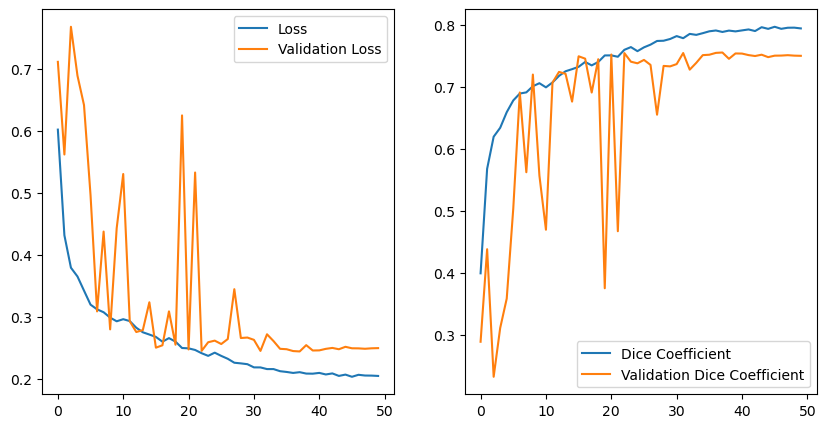

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot loss and validation loss
ax1.plot(h.history['loss'], '-', label='Loss')
ax1.plot(h.history['val_loss'], '-', label='Validation Loss')
ax1.legend()

# Plot dice coefficient and validation dice coefficient
ax2.plot(h.history['dice_coef'], '-', label='Dice Coefficient')
ax2.plot(h.history['val_dice_coef'], '-', label='Validation Dice Coefficient')
ax2.legend()

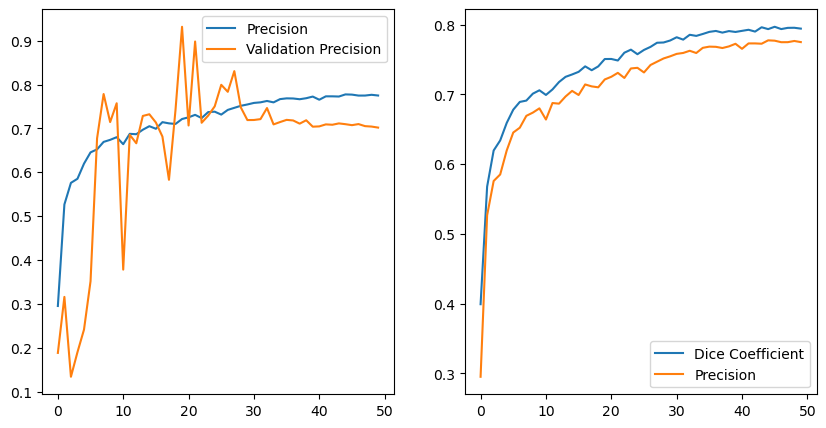

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss
ax1.plot(h.history['precision'], '-', label='Precision')
ax1.plot(h.history['val_precision'], '-', label='Validation Precision')
ax1.legend()

# Plot dice coefficient and precision
ax2.plot(h.history['dice_coef'], '-', label='Dice Coefficient')
ax2.plot(h.history['precision'], '-', label='Precision')
ax2.legend()

In [26]:
def get_test(X_shape, n_samples = 5):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir("/kaggle/input/heart-segmentation-images/img")), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join("/kaggle/input/heart-segmentation-images/img", i))
        im = cv2.resize(im, shape)[:, :, 0]
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

In [27]:
dim, n_samples = 512, 5
X_test = get_test(dim, n_samples = n_samples)
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
X_testNorm = (X_test - 127.0) / 127.0

100%|██████████| 5/5 [00:00<00:00, 22.11it/s]


In [28]:
model.load_weights('/kaggle/working/cxr_heart_weights.best.hdf5')
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 alization)                     )                                                             

1/1 [==============================] - 6s 6s/step


Text(0.5, 1.0, 'predicted mask')

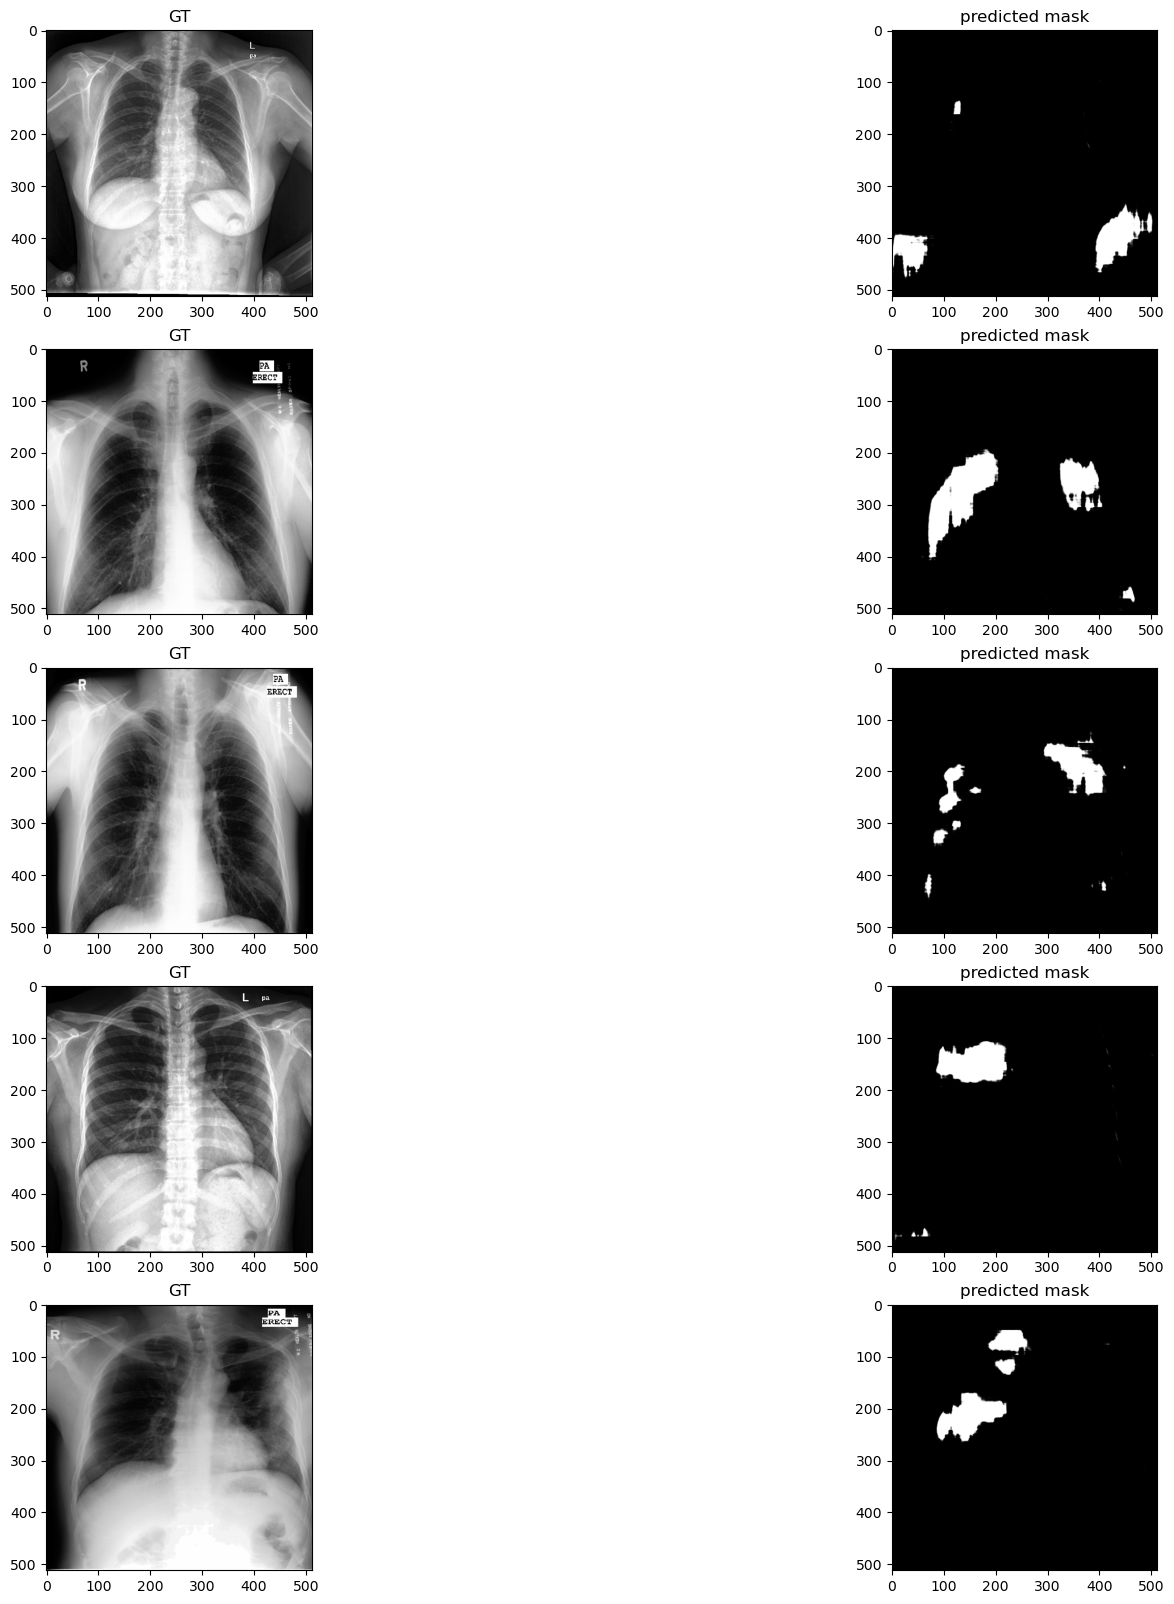

In [29]:
preds = model.predict(X_testNorm)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

axs[0, 0].imshow(np.squeeze(X_testNorm[0]), cmap='gray')
axs[0, 0].set_title('GT')

axs[0, 1].imshow(np.squeeze(preds[0]), cmap='gray')
axs[0, 1].set_title('predicted mask')

axs[1, 0].imshow(np.squeeze(X_testNorm[1]), cmap='gray')
axs[1, 0].set_title('GT')

axs[1, 1].imshow(np.squeeze(preds[1]), cmap='gray')
axs[1, 1].set_title('predicted mask')

axs[2, 0].imshow(np.squeeze(X_testNorm[2]), cmap='gray')
axs[2, 0].set_title('GT')

axs[2, 1].imshow(np.squeeze(preds[2]), cmap='gray')
axs[2, 1].set_title('predicted mask')

axs[3, 0].imshow(np.squeeze(X_testNorm[3]), cmap='gray')
axs[3, 0].set_title('GT')

axs[3, 1].imshow(np.squeeze(preds[3]), cmap='gray')
axs[3, 1].set_title('predicted mask')

axs[4, 0].imshow(np.squeeze(X_testNorm[4]), cmap='gray')
axs[4, 0].set_title('GT')

axs[4, 1].imshow(np.squeeze(preds[4]), cmap='gray')
axs[4, 1].set_title('predicted mask')